In [1]:
import pandas as pd
import numpy as np

cols= ['Q{}'.format(idx) for idx in range(1,11)]
data= pd.read_csv('IRT//ouirt.dat', sep= ' ', names= cols)
data.head(2)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
NaN,0,1,1,1,1,1,1,1,1,0
NaN,0,1,0,0,1,0,1,0,0,0


In [2]:
data= pd.DataFrame(data.values, columns=cols)
data.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.150000,0.268000,0.318000,0.296000,0.438000,0.314000,0.412000,0.334000,0.318000,0.070000
std,0.357429,0.443361,0.466166,0.456948,0.496638,0.464581,0.492688,0.472112,0.466166,0.255403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


*  truncating Question items to 3

In [3]:
rel_items = cols[:3]#Q1,Q2,Q3
df = data[rel_items]
df.head(3)

,Q1,Q2,Q3
0,0,1,1
1,0,1,0
2,0,0,0


In [4]:
df_cols = ['user','questions', 'response']#final dataframe cols

In [5]:
#pd.DataFrame({'user': list(range(df.shape[0]*3)), 
# 'questions':['Q1']*500+ ['Q2']*500+ ['Q3']*500,'response':pd.concat([df[feat_cols[0]],
# df[feat_cols[1]], df[feat_cols[2]]]).values})

In [6]:
from collections import defaultdict
di = defaultdict(dict)
for idx in rel_items:
    di[idx].update(zip(range(df.shape[0]), df[idx].values))#makes format {'Q1':{user:responses,1:0,2:0,. . .,}}

* Following dataframe contains-- user id, questions id, corresponding response value

In [7]:
df_list= list()
for ques, user_resp in list(zip(di.keys(), di.values())):
    df_list.append({'user':list(user_resp.keys()), 'questions':[ques]*df.shape[0], 'response':list(user_resp.values())})

df1=pd.DataFrame(df_list[0])
df2=pd.DataFrame(df_list[1])
df3=pd.DataFrame(df_list[2])
df_new= pd.concat([df1,df2,df3], ignore_index=True)
df_new = df_new.loc[np.random.randint(0,1499, size=1500)]#shuffling data
df_new

,user,questions,response
1061,61,Q3,0
1283,283,Q3,1
714,214,Q2,0
14,14,Q1,0
1229,229,Q3,0
...,...,...,...
23,23,Q1,0
581,81,Q2,1
1432,432,Q3,0
707,207,Q2,0


### Defining Keras equivalent model

In [8]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras import metrics
from keras.utils import to_categorical

Using TensorFlow backend.
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kev/Desktop/pyvirtual2/lib/pytho

In [9]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(df_new[df_cols[:-1]], df_new[df_cols[-1]], test_size=0.05)

In [10]:
x_train_user = to_categorical(xtrain['user'])#contains the one-hot encoded user data
x_train_questions = pd.get_dummies(xtrain['questions']).values#contains the one-hot encoded questions

y_train= ytrain.values
print('shape of x_train_user:', x_train_user.shape,'\nshape of x_train_questions:', x_train_questions.shape,
      '\nshape of y_train:',y_train.shape)

shape of x_train_user: (1425, 500) 
shape of x_train_questions: (1425, 3) 
shape of y_train: (1425,)


### 1 PL IRT model:
* tj= Degree of latent trait
* bj= difficulty_level

`P(i=1,f(tj, bj)) = Simoid[(tj - bj)]`

In [11]:
user_input_layer = Input(shape=(x_train_user.shape[1],))#top half of input taking input feature 1
quest_input_layer = Input(shape=(x_train_questions.shape[1],))#bottom half of input taking input feature 2

latent_trait = Dense(100, use_bias=False)(user_input_layer)
difficulty_level = Dense(100, use_bias=False)(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract()([latent_trait, difficulty_level])


prediction_output = Dense(1, activation='sigmoid')(latent_difficulty_subtract)

model1 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)

model1.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          50000       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          300         input_2[0][0]                    
____________________________________________________________________________________________

In [13]:
history= model1.fit(x=[x_train_user,x_train_questions], y=y_train, epochs=8, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 1140 samples, validate on 285 samples
Epoch 1/8
1140/1140 [==============================] - 1s 539us/step - loss: 0.6118 - mae: 0.4491 - accuracy: 0.7526 - val_loss: 0.5991 - val_mae: 0.4390 - val_accuracy: 0.7544
Epoch 2/8
1140/1140 [==============================] - 0s 52us/step - loss: 0.5914 - mae: 0.4319 - accuracy: 0.7526 - val_loss: 0.5822 - val_mae: 0.4239 - val_accuracy: 0.7544
Epoch 3/8
1140/1140 [==============================] - 0s 51us/step - loss: 0.5778 - mae: 0.4189 - accuracy: 0.7526 - val_loss: 0.5706 - val_mae: 0.4118 - val_accuracy: 0.7544
Epoch 4/8
1140/1140 [==============================] - 0s 61us/step - loss: 0.5683 - mae: 0.4082 - accuracy: 0.7526 - val_loss: 0.5628 - val_mae: 0.4023 - val_accuracy: 0.7544
Epoch 5/8
1140/1140 [==============================] - 0s 63us/step - loss: 0.5619 - mae: 0.3998 - accuracy: 0.7526 - val_loss: 0.5573 - val_mae: 0.3948 - val_accuracy: 0.7544
Epoch 6/8
1140/1140 [===

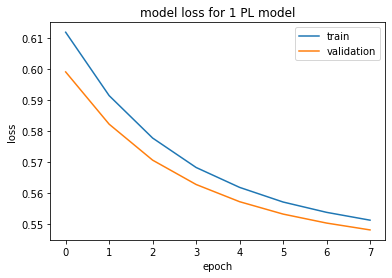

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss for 1 PL model')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')
plt.show()

### 2 PL IRT model
* tj= Degree of latent trait
* bj= difficulty level
* aj= discrimination parameter

`P{i=1,f(tj, bj)} = Simoid[aj(tj - bj)]`

In [16]:
user_input_layer = Input(shape=(x_train_user.shape[1],))#top half of input taking input feature 1
quest_input_layer = Input(shape=(x_train_questions.shape[1],))#bottom half of input taking input feature 2

latent_trait = Dense(100, use_bias=False)(user_input_layer)

difficulty_level = Dense(100, use_bias=False)(quest_input_layer)
discrimination_param = Dense(100, use_bias=False)(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract()([latent_trait, difficulty_level])

disc_param_interaction = keras.layers.Multiply()([latent_difficulty_subtract, 
                                                    discrimination_param])


prediction_output = Dense(1, activation='sigmoid')(disc_param_interaction)

model2 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)

model2.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

In [17]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 100)          50000       input_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          300         input_4[0][0]                    
____________________________________________________________________________________________

In [18]:
history= model2.fit(x=[x_train_user,x_train_questions], y=y_train, epochs=8, verbose=1, validation_split=0.2)

Train on 1140 samples, validate on 285 samples
Epoch 1/8
1140/1140 [==============================] - 0s 177us/step - loss: 0.6765 - mae: 0.4913 - accuracy: 0.7509 - val_loss: 0.6664 - val_mae: 0.4858 - val_accuracy: 0.7544
Epoch 2/8
1140/1140 [==============================] - 0s 50us/step - loss: 0.6576 - mae: 0.4807 - accuracy: 0.7526 - val_loss: 0.6490 - val_mae: 0.4756 - val_accuracy: 0.7544
Epoch 3/8
1140/1140 [==============================] - 0s 61us/step - loss: 0.6419 - mae: 0.4710 - accuracy: 0.7526 - val_loss: 0.6347 - val_mae: 0.4664 - val_accuracy: 0.7544
Epoch 4/8
1140/1140 [==============================] - 0s 63us/step - loss: 0.6289 - mae: 0.4624 - accuracy: 0.7526 - val_loss: 0.6227 - val_mae: 0.4582 - val_accuracy: 0.7544
Epoch 5/8
1140/1140 [==============================] - 0s 63us/step - loss: 0.6181 - mae: 0.4547 - accuracy: 0.7526 - val_loss: 0.6126 - val_mae: 0.4506 - val_accuracy: 0.7544
Epoch 6/8
1140/1140 [==============================] - 0s 60us/step - lo

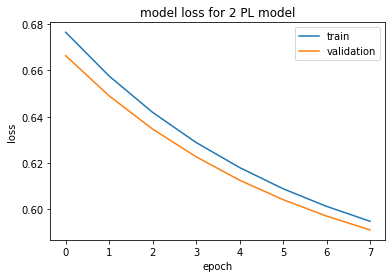

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss for 2 PL model')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')
plt.show()

### 3 PL IRT model
* tj= Degree of latent trait
* bj= difficulty level
* aj= discrimination parameter
* cj= pseudo guessing parameter

`P{i=1,f(tj, bj)} = Simoid[cj+ aj(1-cj)(tj - bj)]`

In [20]:
from keras import backend as K

In [21]:
user_input_layer = Input(shape=(x_train_user.shape[1],))#top half of input
quest_input_layer = Input(shape=(x_train_questions.shape[1],))#bottom half of input

latent_trait = Dense(100, use_bias=False)(user_input_layer)

difficulty_level = Dense(100, use_bias=False)(quest_input_layer)
discrimination_param = Dense(100, use_bias=False)(quest_input_layer)
guess_param = Dense(100, use_bias=False)(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract()([latent_trait, difficulty_level])

disc_param_interaction = keras.layers.Multiply()([latent_difficulty_subtract, 
                                                    discrimination_param])

guess_param_interaction= keras.layers.Multiply()([K.constant(value=np.array([-1])), guess_param])
guess_param_interaction= keras.layers.Add()([K.constant(value=np.array([1])), guess_param_interaction])
guess_param_interaction= keras.layers.Multiply()([disc_param_interaction, 
                                                guess_param_interaction])

guess_param_interaction= keras.layers.Add()([guess_param, guess_param_interaction])


prediction_output = Dense(1, activation='sigmoid')(guess_param_interaction)

#model3 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)

#model3.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])
#model3.summary()

* 3 PL model has some errors & is Not correctly implemented.

In [22]:
model3 = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)

AttributeError: 'NoneType' object has no attribute '_inbound_nodes'